# Halo sensitivity maps

__last update__: 17/11/21

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
from astropy.io import fits
from matplotlib.colors import LogNorm, TwoSlopeNorm
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util

## Global settings

In [2]:
# Save figures on disk?
SAVE_FIGURES = True

# Type of the potential perturbations that we seek to recover
perturbation_type = 'dark_halo' # supported choices: 'dark_halo', 'dark_halo_ps', 'GRF', 'discyness', 'boxyness'
halo_profile = 'SIS'  # 'POINT_MASS', 'SIS'

# Choice of seeing conditions
psf_type = 'gaussian'  # 'gaussian', 'HST'
# Warning: 'HST' will take more time as convolutions are performed in real space... for now.

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=2e-2, flux_vmax=2e0, res_vmax=4)

## Simulate the mock data

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_grid = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_grid)
pixel_grid_fit = deepcopy(pixel_grid)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Seeing & instrumental effects

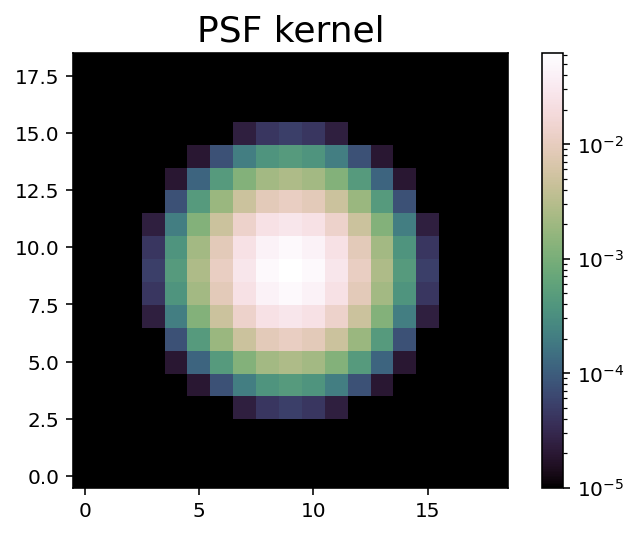

In [4]:
# PSF
if psf_type == 'gaussian':
    # Gaussian PSF
    psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
    convolution_type = None  # ignored when using gaussian PSF (blurring performed through fast gaussian filtering)
elif psf_type == 'HST':
    # PSF from HST F160W
    psf_kernel = fits.getdata(os.path.join('data', 'PSF_HST_F160W_tinytim.fits'), header=False)
    psf_kernel = psf_kernel[25:-25, 25:-25] # trim it a bit so convolutions are faster
    psf_kernel /= psf_kernel.sum()
    print(psf_kernel.shape, psf_kernel.sum())
    psf = PSF(psf_type='PIXEL', kernel_point_source=psf_kernel)
    convolution_type = 'grid'
plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

# Noise
exp_time = 2000
sigma_bkd = 0.01
noise = Noise(npix, npix, background_rms=sigma_bkd, exposure_time=exp_time)
noise_fit = deepcopy(noise)

### Mass and light models

In [5]:
# Input lens mass model 
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_ext_shear_input['gamma1'], kwargs_ext_shear_input['gamma2'])
print(f"Input shear strength: {gamma_ext:.3f} & direction: {phi_ext*180/np.pi:.3f}")
phi, q = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
print(f"Input macro axis ratio: {q:.3f} & direction: {phi*180/np.pi:.3f}")

# Input potential perturbations
if perturbation_type == 'dark_halo':
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'SIE'])
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'theta_E': 0.12, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}
    ]
    
elif perturbation_type == 'dark_halo_ps':
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'POINT_MASS'])
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'theta_E': 0.16, 'center_x': 1.9, 'center_y': -0.4}
    ]
    
elif perturbation_type in ['discyness', 'boxyness']:
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'MULTIPOLE'])
    phi_macro_lens, _ = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
    if perturbation_type == 'discyness':
        phi_shift = 0
    elif perturbation_type == 'boxyness':
        phi_shift = 45*np.pi/180.
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'m': 4, 'a_m': 0.2, 'phi_m': phi_macro_lens + phi_shift, 'center_x': 0.0, 'center_y': 0.0}
    ]
    
elif perturbation_type == 'GRF':
    logA = -3.8
    beta = -5
    phase = 42
    box_length = 2 * np.pi * npix * pix_scl
    pb = pbox.PowerBox(N=npix, dim=2, pk=(lambda k: 10**logA * k**beta), boxlength=box_length, seed=phase)
    psi_grid_input = pb.delta_x()
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'PIXELATED'])
    kwargs_lens_input = [
        kwargs_macro_lens_input, kwargs_ext_shear_input,
        {'pixels': psi_grid_input},
    ]
    plt.figure()
    plt.imshow(psi_grid_input, origin='lower')
    plt.show()

# Fitted lens mass model
lens_mass_model_fit = LensModel(['SIE', 'SHEAR'])

# Input source model 
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]

# Input lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 30.0, 'R_sersic': 2., 'n_sersic': 2., 
     'e1': kwargs_macro_lens_input['e1'], 'e2': kwargs_macro_lens_input['e2'], 
     'center_x': kwargs_macro_lens_input['center_x'], 'center_y': kwargs_macro_lens_input['center_y']}
]

Input shear strength: 0.032 & direction: 54.217
Input macro axis ratio: 0.731 & direction: -7.466


### Image model classes, for both simulate and fit

In [6]:
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': convolution_type}

# True image model
lens_image_input = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_input,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

# Hybrid image model for fitting
lens_image_fit = LensImage(pixel_grid_fit, psf, noise_class=noise_fit,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

In [7]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_input = lens_image_input.LensModel.potential(x_grid, y_grid, kwargs_lens_input, k=-1)

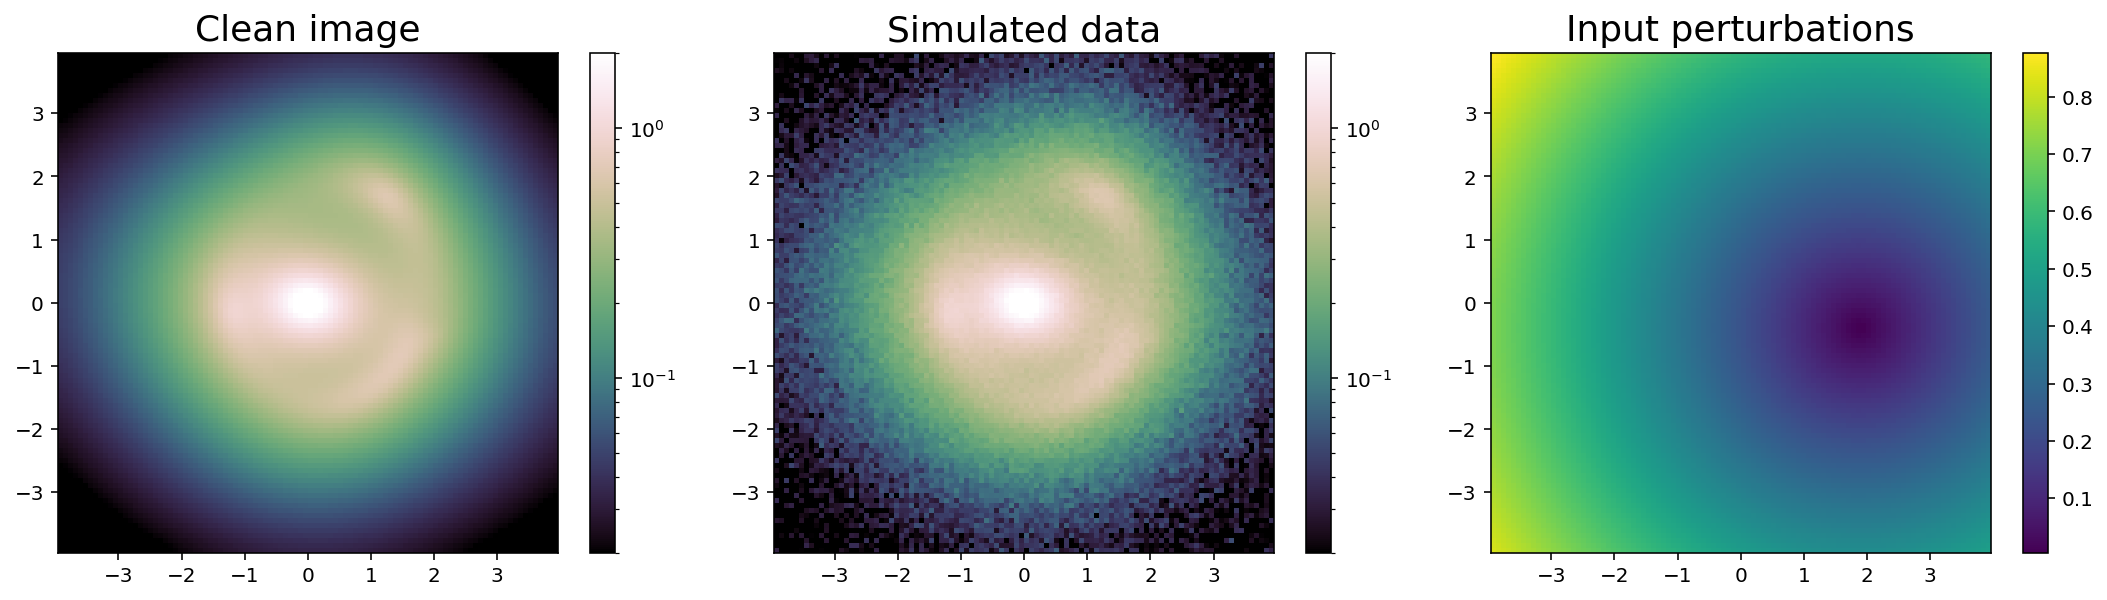

In [8]:
# Generate a lensed image based on source and lens models
clean_image = lens_image_input.model(kwargs_lens=kwargs_lens_input,
                              kwargs_source=kwargs_source_input,
                              kwargs_lens_light=kwargs_lens_light_input)

# Observed noisy data
data = lens_image_input.simulation(kwargs_lens=kwargs_lens_input,
                                   kwargs_source=kwargs_source_input,
                                   kwargs_lens_light=kwargs_lens_light_input,
                                   noise_seed=18)

# here we assume that the noise is perefectly known
#lens_image_fit.Noise.set_data(clean_image)
lens_image_fit.Noise.compute_noise_map_from_model(clean_image, as_jax_array=False)

# get the true source surface brightness
source_input = lens_image_input.source_surface_brightness(kwargs_source_input,
                                                          de_lensed=True, unconvolved=True)
source_input_lensed = lens_image_input.source_surface_brightness(kwargs_source_input, kwargs_lens=kwargs_lens_input,
                                                                 de_lensed=False, unconvolved=False)

# inform the plotter for later
plotter.set_data(data)
plotter.set_ref_source(source_input)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("Clean image", fontsize=18)
im = ax.imshow(clean_image, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("Simulated data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("Input perturbations", fontsize=18)
im = ax.imshow(psi_grid_input, origin='lower', extent=extent, cmap=plotter.cmap_default)
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

## Model fitting

### Prepare the parameters (initial values, constraints, etc.)

In [9]:
kwargs_init = {
    'kwargs_lens': [deepcopy(kwargs_lens_input[0]), deepcopy(kwargs_lens_input[1])],
    'kwargs_source': deepcopy(kwargs_source_input),
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0.0, 'dec_0': 0.}], 
    'kwargs_source': [{}],
    'kwargs_lens_light': kwargs_lens_light_input,  # lens light is fixed
}
kwargs_joint = {
    # fix lens center to lens light center
    'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
}
parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed, 
                        kwargs_joint=kwargs_joint, kwargs_prior=None)
print("Number of fitted parameters:", parameters.num_parameters)

Number of fitted parameters: 12


### Fit source and macro lens model

Initial loss: 2.790961
Number of data points in likelihood: 10000
Runtime: 6.26462984085083
Loss at best-fit: 1.1383892


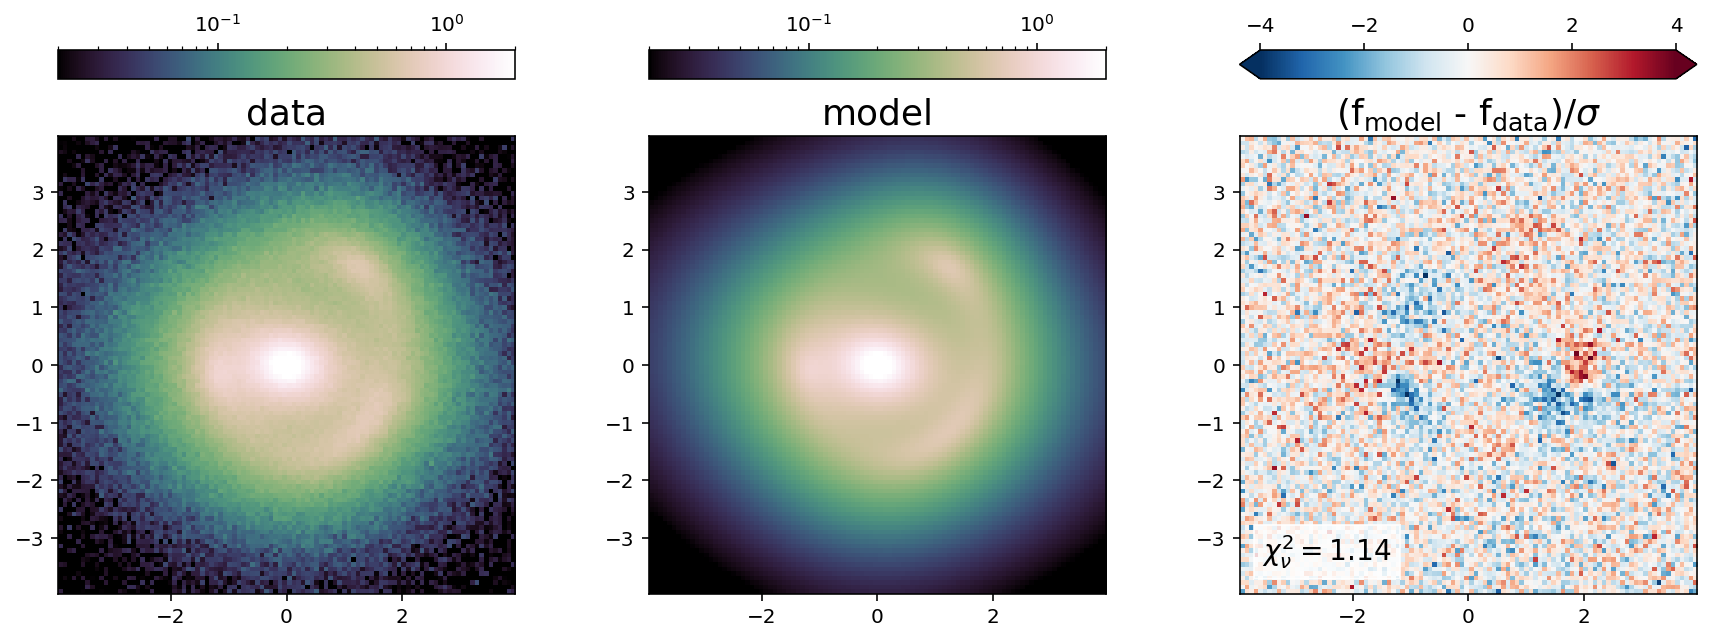

In [10]:
# Create loss
loss_smooth_fit = Loss(data, lens_image_fit, parameters, 
                            likelihood_type='chi2', prior_terms=None)
print("Initial loss:", loss_smooth_fit(parameters.kwargs2args(kwargs_init)))
print("Number of data points in likelihood:", loss_smooth_fit.likelihood_num_data_points)

# Optimizer
optimizer_smooth_fit = Optimizer(loss_smooth_fit, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer_smooth_fit.minimize(method='BFGS', restart_from_init=True,
                                    use_exact_hessian_if_allowed=False)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_smooth_fit(best_fit))
kwargs_smooth_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

fig = plotter.model_summary(lens_image_fit, kwargs_smooth_fit, show_source=False)
plt.show()

## Sensitivity map to a subhalo as partial derivatives w.r.t. to subhalo mass 

In [11]:
#%%time
sensiv_map_sis, (x_minima, y_minima) \
    = model_util.halo_sensitivity_map(lens_image_fit, parameters, data, 
                                      halo_profile=halo_profile)

num. params: 3
init. params: [0. 0. 0.]


ValueError: s must be a scalar, or float array-like with the same size as x and y

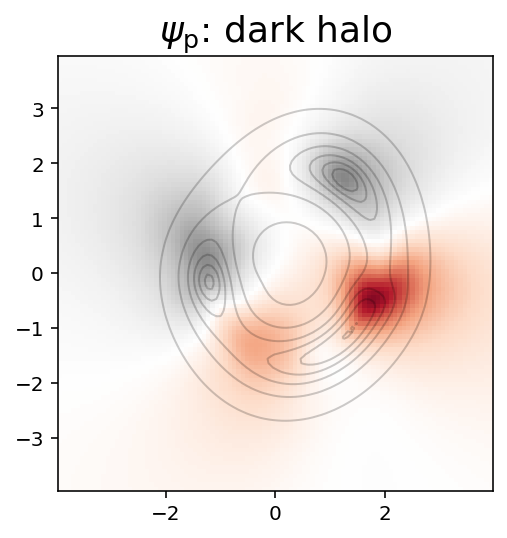

In [14]:
#vmax = np.abs(sensiv_map_sis).max()
if halo_profile == 'POINT_MASS':
    vmax = 10
else:
    vmax = 2
#levels = np.array([0.05, 0.1, 0.2]) / source_input_lensed.max()

fig, axes = plt.subplots()
ax = axes
#ax.set_title("sensitivity map\nfor a SIS subhalo", fontsize=18)
ax.set_title(r"$\psi_{\rm p}$: " + f"{perturbation_type.replace('_', ' ')}", fontsize=18)
im = ax.imshow(sensiv_map_sis, origin='lower', 
               vmin=-vmax, vmax=vmax,
               cmap='RdGy', extent=extent)
ax.contour(source_input_lensed, colors='black', #levels=levels, 
           linewidths=1, alpha=0.2, extent=extent, zorder=5)
ax.scatter(x_minima, y_minima, c='white', s=60, marker='v',
           edgecolors='#000000aa', linewidths=0.5,
           alpha=0.7, zorder=10)
fig.colorbar(im, ax=ax).set_label("$\Delta\mathcal{E}$", size=20)
plt.show()

if SAVE_FIGURES:
    halo_profile_short = 'PM' if halo_profile == 'POINT_MASS' else halo_profile
    fig_name = f'wavelet_pot-smooth_src-input_{perturbation_type}-sensit_{halo_profile_short}'
    fig_path = os.path.join('figures', 'sensitivity maps', fig_name + '.pdf')
    fig.savefig(fig_path, dpi=100, bbox_inches='tight')

## Re-optimizing the model for each subhalo position

In [13]:
#TODO